# Zadanie nr 4 - Odległość edycyjna

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from spacy.lang.pl import Polish
from random import random

In [2]:
def print_2d(l): return print(
    '\n'.join(map(''.join, list(map(lambda x: str(x).replace("'", ""), l)))))

## 1. Odległość edycyjna

#### odległość levensheita

In [46]:
LEFT = '\u2190'
UP = '\u2191'
DIAG = '\u2196'

print(LEFT, UP, DIAG)

← ↑ ↖


In [47]:
def levensheit(text_a, text_b, delta=None):
    edit = [[None for _ in range(len(text_b) + 1)]
            for _ in range(len(text_a) + 1)]
    path = [[None for _ in range(len(text_b) + 1)]
            for _ in range(len(text_a) + 1)]

    if delta is None:
        def delta(char_a, char_b): return 0 if char_a == char_b else 1

    for i in range(len(text_a) + 1):
        edit[i][0] = i
        path[i][0] = UP

    for j in range(1, len(text_b) + 1):
        edit[0][j] = j
        path[0][j] = LEFT

    for i in range(1, len(text_a)+1):
        for j in range(1, len(text_b)+1):
            options = [edit[i-1][j] + 1, edit[i][j-1] + 1,
                       edit[i-1][j-1] + delta(text_a[i-1], text_b[j-1])]
            edit[i][j] = min(options)

            if edit[i][j] == options[0]:
                path[i][j] = UP
            elif edit[i][j] == options[1]:
                path[i][j] = LEFT
            else:
                path[i][j] = DIAG

    return edit[len(text_a)][len(text_b)], edit, path

In [48]:
NEXT = 0
INSERT = 1
DELETE = 2
REPLACE = 3

In [74]:
def get_steps(text_a, text_b, edit=None, path=None):
    if edit is None:
        _, edit, path = levensheit(text_a, text_b)
        
    i, j = len(text_a), len(text_b)
    steps = []

    while i > 0 or j > 0:
        if path[i][j] == LEFT:
            steps.append([INSERT, text_b[j-1]])
            j -= 1
        elif path[i][j] == UP:
            steps.append([DELETE, text_a[i-1]])
            i -= 1
        else:
            if path[i][j] == DIAG and edit[i][j] != edit[i-1][j-1]:
                steps.append([REPLACE, text_a[i-1], text_b[j-1]])
            else:
                steps.append([NEXT])

            i -= 1
            j -= 1
            
    return reversed(steps)

In [79]:
def transform(text_a, text_b, steps):
    i = 0
    current = text_a
    states = [current]

    for step in steps:
        if step[0] == INSERT:
            current = current[:i] + step[1] + current[i:]
            states.append(current[:i] + '*' + current[i] + '*' + current[i+1:])
        elif step[0] == REPLACE:
            current = current[:i] + step[2] + current[i+1:]
            states.append(current[:i] + '*' + current[i] + '*' + current[i+1:])
        elif step[0] == DELETE:
            current = current[:i] + current[i+1:] if i + \
                1 < len(current) else current[:i]
            states.append(current[:i]+'**'+current[i:])
            i -= 1

        i += 1

    return states

In [80]:
text_a, text_b = "los", "kloc"
value, edit, path = levensheit(text_a, text_b)
steps = get_steps(text_a, text_b, edit, path)
print_2d(edit)
print()
print_2d(path)
print("\ndistance: ", value)

[0, 1, 2, 3, 4]
[1, 1, 1, 2, 3]
[2, 2, 2, 1, 2]
[3, 3, 3, 2, 2]

[↑, ←, ←, ←, ←]
[↑, ↖, ↖, ←, ←]
[↑, ↑, ↑, ↖, ←]
[↑, ↑, ↑, ↑, ↖]

distance:  2


#### animacja

In [84]:
def animate(states):
    fig, ax = plt.subplots(figsize=(8.5, 2))
    time_text = ax.text(0, 0.5, '', fontsize=40)
    plt.axis('off')

    def updatefig(num):
        time_text.set_text(states[num])
        return time_text,

    return animation.FuncAnimation(fig, updatefig, interval=500, frames=len(states))

kwintesencja
*q*wintesencja
q*u*intesencja
quintes*s*encja
quintessenc*e*a
quintessence**


<IPython.core.display.Javascript object>


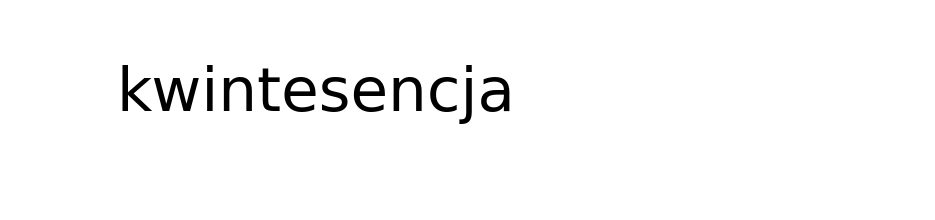

los
*k*los
klo*c*


<IPython.core.display.Javascript object>


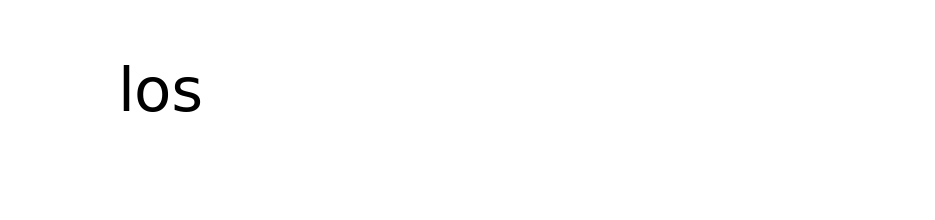

Łódź
*L*ódź
L*o*dź
Lod*z*


<IPython.core.display.Javascript object>


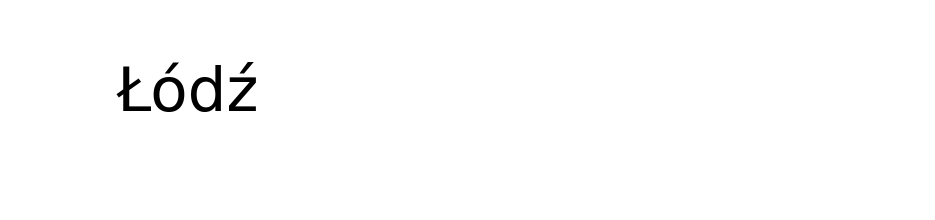

ATGAATCTTACCGCCTCG
ATGA*G*TCTTACCGCCTCG
ATGAG*G*CTTACCGCCTCG
ATGAGGCT*C*TACCGCCTCG
ATGAGGCTCT*G*CCGCCTCG
ATGAGGCTCTG*G*CCGCCTCG
ATGAGGCTCTGGCC**CCTCG
ATGAGGCTCTGGCCCCT**G


<IPython.core.display.Javascript object>


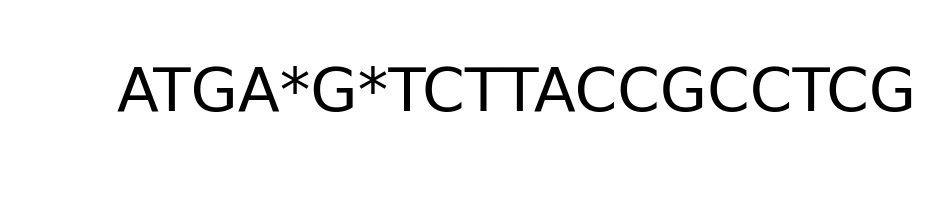

In [85]:
%matplotlib notebook

animated = []

for text_a, text_b in [("kwintesencja", "quintessence"), ("los", "kloc"), ("Łódź", "Lodz"), ("ATGAATCTTACCGCCTCG", "ATGAGGCTCTGGCCCCTG")]:
    states = transform(text_a, text_b, get_steps(text_a, text_b))
    print_2d(states)
    animated.append(animate(states))
    plt.draw()
    plt.show()

## 2. Najdłuższy wspólny podciąg

#### lcs

In [86]:
def get_lcs(text_a, text_b):
    def delta(x, y): return 0 if str(x) == str(y) else 2
    dist, edit, path = levensheit(text_a, text_b, delta)

    i, j = len(text_a), len(text_b)
    common = []

    while i > 0 or j > 0:
        if path[i][j] == LEFT:
            j -= 1
        elif path[i][j] == UP:
            i -= 1
        else:
            if path[i][j] == DIAG:
                common.append((i-1, j-1, text_a[i-1]))
            i -= 1
            j -= 1

    lcs = ''.join(str(x[2]) for x in reversed(common))
    return dist, lcs, common

#### podział tekstu na tokenu, wybranie losowej części

In [98]:
nlp = Polish()
tokenizer = nlp.tokenizer

with open('romeo-i-julia-700.txt', 'r') as f, open('file_a.txt', 'w') as f_a, open('file_b.txt', 'w') as f_b:
    for line in f:
        tokens = tokenizer(line)
        for token in tokens[:-1]:
            if random() > 0.03:
                f_a.write(str(token))
                f_a.write(' ')
                
            if random() > 0.03:
                f_b.write(str(token))
                f_b.write(' ')
            
        f_a.write('\n')
        f_b.write('\n')

#### diff

In [114]:
def print_diff(line_a, line_b, num):
    dist, lcs, common = get_lcs(line_a, line_b)
    i = 0

    if dist == 0:
        return

    common_a = set(x[0] for x in common)
    common_b = set(x[1] for x in common)

    print(
        f"< {num} | {' '.join(str(c) for i, c in enumerate(line_a) if i not in common_a)}")
    print(
        f"> {num} | {' '.join(str(c) for i, c in enumerate(line_b) if i not in common_b)}\n")

In [115]:
def diff(file_a, file_b):
    nlp = Polish()
    tokenizer = nlp.tokenizer
    with open(file_a, 'r') as f_a, open(file_b, 'r') as f_b:
        for i, lines in enumerate(zip(f_a, f_b)):
            print_diff(tokenizer(lines[0]), tokenizer(lines[1]), i)

In [116]:
diff('file_a.txt', 'file_b.txt')

< 3 | 
> 3 | .

< 11 | 
> 11 | —

< 13 |   
> 13 | Kapuleta

< 14 | 
> 14 | —

< 17 | 
> 17 | —

< 18 | —
> 18 | 

< 19 | — zgromadzenia
> 19 | 

< 23 |   
> 23 | 

< 24 | MUZYKANTÓW
> 24 | 

< 28 | 
> 28 | Montekiego

< 29 | 
> 29 | *

< 30 | 
> 30 | Kapuletów

< 32 | maski
> 32 | 

< 45 | 
> 45 | rody

< 48 | szlachetną
> 48 | krwią

< 51 | najstraszliwszą ;
> 51 | 

< 57 | ją
> 57 | 

< 107 | 
> 107 | .

< 112 | :
> 112 | walecznym

< 122 | nikogo
> 122 | niestraszny

< 127 | 
> 127 | to kobiety tulą .

< 132 | 
> 132 | i

< 137 | mi , między
> 137 | o ,

< 140 | GRZEGORZ
> 140 | 

< 147 | :
> 147 | ,

< 152 | .
> 152 | , oto nadchodzi

< 154 | .
> 154 | 

< 189 | 
> 189 | jak

< 194 | 
> 194 | panie

< 199 | 
> 199 | inaczej

< 211 | 
> 211 | powiem

< 214 | GRZEGORZ
> 214 | 

< 221 | sobie
> 221 | 

< 238 | szukasz waścine
> 238 | 

< 257 | z
> 257 | 

< 292 | 
> 292 | pokój

< 293 | ludzi
> 293 | Albo ze

< 303 | i
> 303 | wkrótce

< 325 | 
> 325 | KAPULET

< 339 | 
> 339 |      

## Wnioski

- odległość edycyjna może posłużyć do znajdowania najdłuższego wspólnego podciągu
- znalezienie najdłuższego wspólnego podciągu może posłużyć do znajdowania różnic pomiędzy tekstami, np. w programach typu version control

M. Hawryluk 01.05.2021